## Intent Classification for the ATIS Dataset using BERT.
In this notebook we build a classifier for the ATIS Dataset using [BERT](https://arxiv.org/abs/1810.04805), a pre-Trained NLP model open soucred by google in late 2018 that can be used for [Transfer Learning](https://towardsdatascience.com/transfer-learning-in-nlp-fecc59f546e4) on text data. More Details on our approach can be found at this [Article](https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03).The dataset is in the repo.<br>
This notebook requires a GPU to get setup. We suggest you to run this on your local machine only if you have a GPU setup or else you can use google colab.

### Importing
Making the necessary imports and installing the required libraries.


In [1]:
# install
# !pip install pytorch-pretrained-bert=0.4.0 pytorch-nlp
# !pip install seqeval==0.0.12

In [2]:
#importing a few necessary packages and setting the DATA directory
DATA_DIR="."
import os
import numpy as np
import pickle
import tensorflow as tf


# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#importing packages to calculate the f1_score of our model
from seqeval.metrics import f1_score

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

### Dataset
Upload the dataset into colab

In [3]:
#importing the dataset
#upload the "atis.test.w-intent.iob" and atis.train.w-intent.iob" present in data2 folder
# try:
#     from google.colab import files
#     uploaded = files.upload()
# except ModuleNotFoundError:
#     print('Not using colab')

### Preprocessing
We need to read data from the .iob files. Hence we need a few preprocessing helper functions. The below functions can be found in the utils.py file.

In [4]:
#preprocessing functions
def get_data(filename):
    df = pd.read_csv(filename,delim_whitespace=True,names=['word','label'])
    beg_indices = list(df[df['word'] == 'BOS'].index)+[df.shape[0]]
    sents,labels,intents = [],[],[]
    for i in range(len(beg_indices[:-1])):
        sents.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['word'].values)
        labels.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['label'].values)
        intents.append(df.loc[beg_indices[i+1]-1]['label'])    
    # return np.array(sents),np.array(labels),np.array(intents)
    return sents, labels, intents

def get_data2(filename):
    with open(filename) as f:
        contents = f.read()
    sents,labels,intents = [],[],[]
    for line in contents.strip().split('\n'):
        words,labs = [i.split(' ') for i in line.split('\t')]
        sents.append(words[1:-1])
        labels.append(labs[1:-1])
        intents.append(labs[-1])
    # print(np.array(sents))
    # print(np.array(labels))
    # print(np.array(intents))
    # return np.array(sents),np.array(labels),np.array(intents)
    return sents, labels, intents

Reading the training data

In [5]:
print("Loading the training Data")

# try:
#     from google.colab import files
#     sents,labels,intents = get_data2('atis.train.w-intent.iob')
# except ModuleNotFoundError:
#     sents,labels,intents = get_data2('Data/data2/atis.train.w-intent.iob')

sents,labels,intents = get_data2('../data/6ch/data2/atis.train.w-intent.iob')
sents = sents[:200]
labels = labels[:200]
intents = intents[:200]
train_sentences = [" ".join(i) for i in sents]

train_texts = train_sentences
# train_labels= intents.tolist()
train_labels = intents

vals = []

for i in range(len(train_labels)):
    if "#" in train_labels[i]:
        vals.append(i)
        
for i in vals[::-1]:
    train_labels.pop(i)
    train_texts.pop(i)

print ("Number of training sentences :",len(train_texts))
print ("Number of unique intents :",len(set(train_labels)))

for i in zip(train_texts[:5], train_labels[:5]):
    print(i)

Loading the training Data
Number of training sentences : 200
Number of unique intents : 12
('i want to fly from boston at 838 am and arrive in denver at 1110 in the morning', 'atis_flight')
('what flights are available from pittsburgh to baltimore on thursday morning', 'atis_flight')
('what is the arrival time in san francisco for the 755 am flight leaving washington', 'atis_flight_time')
('cheapest airfare from tacoma to orlando', 'atis_airfare')
('round trip fares from pittsburgh to philadelphia under 1000 dollars', 'atis_airfare')


Reading the Test data

In [6]:
# try:
#     from google.colab import files
#     sents,labels,intents = get_data('atis.test.w-intent.iob')
# except ModuleNotFoundError:
#     sents,labels,intents = get_data('Data/data2/atis.test.w-intent.iob')

sents,labels,intents = get_data('../data/6ch/data2/atis.test.w-intent.iob')
sents = sents[:200]
labels = labels[:200]
intents = intents[:200]
test_sentences = [" ".join(i) for i in sents]

test_texts = test_sentences
# test_labels = intents.tolist()
test_labels = intents

new_labels = set(test_labels) - set(train_labels)

vals = []

for i in range(len(test_labels)):
    if "#" in test_labels[i]:
        vals.append(i)
    elif test_labels[i] in new_labels:
        print(test_labels[i])
        vals.append(i)
        
for i in vals[::-1]:
    test_labels.pop(i)
    test_texts.pop(i)

print ("Number of testing sentences :",len(test_texts))
print ("Number of unique intents :",len(set(test_labels)))

for i in zip(test_texts[:5], test_labels[:5]):
    print(i)

atis_day_name
atis_day_name
atis_meal
atis_meal
atis_meal
Number of testing sentences : 194
Number of unique intents : 11
('i would like to find a flight from charlotte to las vegas that makes a stop in st. louis', 'atis_flight')
('on april first i need a ticket from tacoma to san jose departing before 7 am', 'atis_airfare')
('on april first i need a flight going from phoenix to san diego', 'atis_flight')
('i would like a flight traveling one way from phoenix to san diego on april first', 'atis_flight')
('i would like a flight from orlando to salt lake city for april first on delta airlines', 'atis_flight')


As this is a demonstration we will we using only using the training data. We will split it to get a test and train data.<br>
Converting the data into a pandas dataframe.

In [7]:
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame(data =zip(train_labels,train_texts),columns=['Labels',"Text"])

lb_make = LabelEncoder()
df["Labels"] = lb_make.fit_transform(df["Labels"])

train_texts = list(df['Text'])
train_labels = list(df['Labels'])
print("Length of training labels:",len(train_labels))
print("Length of training texts:",len(train_texts))

Length of training labels: 200
Length of training texts: 200


BERT expects data to be in a specific format, i.e, [CLS] token1,token2,....[SEP]

In [8]:
query_data_train = list(train_texts)
sentences = ["[CLS] " + query + " [SEP]" for query in query_data_train]
print(sentences[0])

# Tokenize with BERT tokenizer

#BERT only takes a token size of 512.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

[CLS] i want to fly from boston at 838 am and arrive in denver at 1110 in the morning [SEP]
Tokenize the first sentence:
['[CLS]', 'i', 'want', 'to', 'fly', 'from', 'boston', 'at', '83', '##8', 'am', 'and', 'arrive', 'in', 'denver', 'at', '111', '##0', 'in', 'the', 'morning', '[SEP]']


In [9]:
# Set the maximum sequence length. 
MAX_LEN = 4
# MAX_LEN = 128
# Pad our input tokens
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Creating the BERT attention masks

In [10]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  

In [11]:
intent_data_label_train = train_labels#renaming 

### Splitting the training data into train and test sets.

In [12]:
# Use train_test_split to split our data into train and validation sets for training


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, 
                                                                                    intent_data_label_train, 
                                                                                    random_state=2020, 
                                                                                    test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks,
                                                       input_ids,
                                                       random_state=2020, 
                                                       test_size=0.1)
                                             
                                             
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Select a batch size for training. 
batch_size = 32

# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=17)
if torch.cuda.is_available():
    model.cuda()
else:
    model

### Fine-Tuning BERT

t_total value of -1 results in schedule not being applied
Epoch:  50%|█████     | 1/2 [00:08<00:08,  8.39s/it]

Train loss: 1.0986706217130024
Validation Accuracy: 0.8


Epoch: 100%|██████████| 2/2 [00:17<00:00,  8.50s/it]

Train loss: 1.108219673236211
Validation Accuracy: 0.75


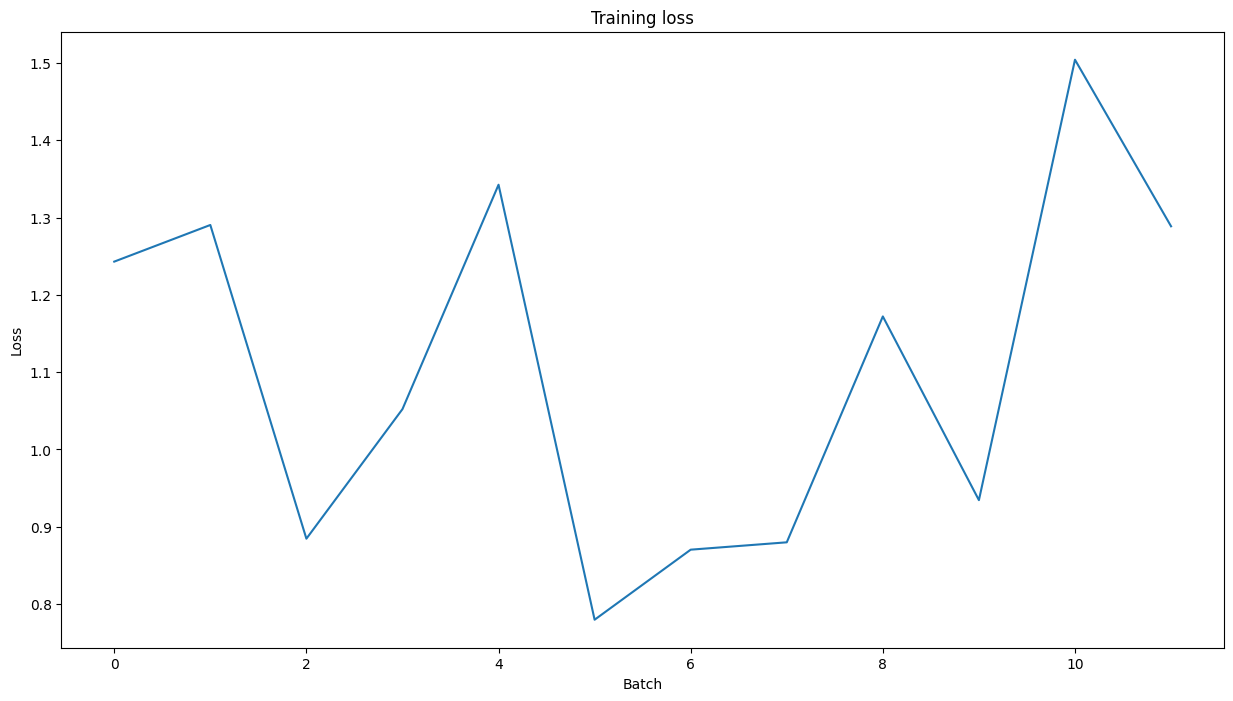

In [15]:
# BERT fine-tuning parameters
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
      {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.01},
      {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
      'weight_decay_rate': 0.0}
  ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = BertAdam(optimizer_grouped_parameters, lr=3e-5)


# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
  
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 2

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ###### TRAINING ######
  
    # Set our model to training mode
    model.train()  
    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ###### VALIDATION ######

  # Put model in evaluation mode
    model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
          # Forward pass, calculate logit predictions
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.savefig('../pngs/6ch_training_loss.png')
plt.show()